# Ajuste de coeficientes de matriz IP utilizando datos de trabajadores asegurados

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import MultiComparison
import seaborn as sb


In [3]:
sector_names = [
    "Industrias Agropecuaria",
    "Industrias Extractivas",
    "",
    "Industrias de Transformacion",
    "Industrias de la Construccion",
    "Ind. Electrica y Suministro Agua pot",
    "Comercio",
    "Transporte y comunicaciones",
    "Servicios para empresa, personal, hogar",
    "Servicios sociales"
]

data = pd.read_csv('./data/HW_Datos_Jal.csv')


data_hw = data.copy()
data_hw.loc[:, "ta"] = data_hw.loc[:, "HWES1"]
data_hw = data_hw.drop("HWES1", axis=1)

selected_data = data_hw.dropna().loc[:, ["sector_economico_1",
                                      "sector_economico_2",
                                      "ta", "Año"]]
selected_data = selected_data[selected_data["Año"] > "2010-01-31"]
selected_data.head()

/var/folders/_w/_rk_yvg13819jy3bf_5jck6w0000gn/T/ipykernel_17786/3302188217.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[40878.         40878.         40913.125      ...   138.80350778
   139.22836162   139.63551322]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  data_hw.loc[:, "ta"] = data_hw.loc[:, "HWES1"]


,sector_economico_1,sector_economico_2,ta,Año
0,0.0,1.0,40878.000000,2010-02-28
1,0.0,1.0,40878.000000,2010-03-31
2,0.0,1.0,40913.125000,2010-04-30
3,0.0,1.0,40804.703125,2010-05-31
4,0.0,1.0,40651.132161,2010-06-30


In [4]:
def get_sector_data_covars(data: pd.DataFrame):
    data = data.copy()
    
    # Main sector data
    sector_data = data.groupby(["Año", "sector_economico_1"])\
        .sum() \
        .reset_index() \
        .drop("sector_economico_2", axis=1) \
        .sort_values(by=["sector_economico_1", "Año"])
    
    # Groups data
    grouped_data = data.groupby(["Año", "sector_economico_1", "sector_economico_2"])\
        .sum() \
        .reset_index()
        
    # Return data
    ret_data = sector_data.copy()
    
    # print(ret_data)
    
    sectors_set = sorted(set(sector_data.sector_economico_1))

    # Adding for each sector
    for sector in sectors_set:
        groups_set = sorted(set(grouped_data[(grouped_data["sector_economico_1"] == sector)]["sector_economico_2"]))
        for group in groups_set:
            employments_per_group = grouped_data[(grouped_data["sector_economico_1"] == sector) &
                                                 (grouped_data["sector_economico_2"] == group)]["ta"]
            try:
                covar_col = list(employments_per_group.values) * 10
                ret_data[f"covar_s{int(sector)}_g{int(group)}"] = covar_col
            except Exception as e:
                print(f"Skipping sector {sector_names[int(sector)]} group {group}, it does not contain the same amount of rows: {len(employments_per_group)}")
                
    return ret_data



In [10]:
sector_df = get_sector_data_covars(selected_data)
covars = list(sector_df.columns)[3:]
covars_df = sector_df.iloc[:162, 3:]
coeffs_df = pd.DataFrame(columns=covars_df.columns)


for c in covars_df.columns:
    X = covars_df.drop(c, axis=1)
    y = covars_df[c]
    X = sm.add_constant(X)
    mod = sm.OLS(y, X)
    res = mod.fit_regularized()
    const = res.params.const
    coef_series = res.params.drop("const")
    coef_series[c] = const
    coef_series.name = c
    coeffs_df[c] = coef_series

In [11]:
coeffs_df

,covar_s0_g1,covar_s0_g2,covar_s0_g3,covar_s0_g4,covar_s0_g5,covar_s1_g11,covar_s1_g12,covar_s1_g13,covar_s2_g20,covar_s2_g21,...,covar_s8_g85,covar_s8_g86,covar_s8_g87,covar_s8_g88,covar_s8_g89,covar_s9_g91,covar_s9_g92,covar_s9_g93,covar_s9_g94,covar_s9_g99
covar_s0_g2,0.173001,17960.411944,-0.000580,0.001427,-0.000223,-0.000016,-0.000050,-0.005513,-0.187753,-0.016916,...,-0.007782,-0.033917,-0.100132,-0.038499,-0.075108,-0.063078,-0.051476,-0.008509,-0.153640,-0.000101
covar_s0_g3,-3.827673,-2.644416,463.848170,-0.163182,-0.005661,-0.025436,-0.005094,0.272585,-3.168874,-1.497983,...,-0.462101,-1.092266,-0.379798,0.397304,0.245045,1.106710,-1.885321,0.531196,-1.430334,0.000878
covar_s0_g4,-3.062745,2.693786,-0.119206,279.060954,0.010551,0.023047,0.006391,-1.705352,1.692702,3.189870,...,0.034461,-3.159587,-10.879205,-5.478233,-5.864722,-8.667175,4.916268,-1.715370,-6.191520,0.009236
covar_s0_g5,621.914672,60.297486,1.160594,4.084992,17.909151,-0.084311,0.126345,12.430661,428.810654,37.495713,...,27.698170,120.857875,300.292059,107.467099,182.084169,164.676304,93.216118,8.969191,318.706338,0.082630
covar_s1_g11,-8.226210,-1.129978,0.015955,-0.017413,-0.002399,1415.508008,-0.002469,0.108052,-6.328994,-0.937041,...,-0.344792,-0.941060,-2.133986,-0.540654,-1.662618,-0.907576,-2.088359,0.115835,-3.330228,-0.003947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
covar_s9_g92,0.040648,0.013389,-0.000400,0.002027,0.000057,0.000550,-0.000014,-0.000979,0.044917,0.023470,...,0.000509,0.009340,-0.010243,-0.003126,0.004733,-0.017584,21906.815538,0.000344,0.027484,0.000060
covar_s9_g93,-0.085941,-0.069717,0.002821,-0.008882,-0.000397,-0.001417,-0.000053,0.026895,-0.136483,-0.095403,...,-0.012486,-0.049218,0.005531,0.034576,0.033444,0.079965,0.023131,6027.924900,0.098169,0.000100
covar_s9_g94,-0.004444,0.000958,-0.000072,0.000174,0.000000,-0.000004,0.000002,-0.000763,-0.002102,0.000551,...,0.000219,-0.000161,-0.001412,-0.001633,-0.002511,-0.002119,-0.000360,0.000018,176734.084311,-0.000008
covar_s9_g99,-3.032327,-0.730983,0.023041,0.118623,0.004667,-0.039744,-0.003020,0.074958,-0.592888,-0.465153,...,-0.303679,-1.465985,-3.931654,-0.466338,-0.113870,-1.215677,0.112211,0.394409,-8.876750,126.903391


## Buscando correlaciones con datos PIB Inegi.

In [12]:
gdp_data = pd.read_csv("./data/Inegi_T1_4.csv").iloc[1:, 1:]
gdp_data.head()

,Año,2010,2010.1,2010.2,2010.3,2011,2011.1,2011.2,2011.3,2012,...,2021,2021.1,2021.2,2021.3,2022,2022.1,2022.2,2022.3,2023,2023.1
1,111 - Agricultura,341063.915,466580.473,323870.597,441958.107,348272.583,385824.919,318443.223,447012.131,362824.69,...,477743.922,578813.189,415695.969,640313.04,479049.254,579839.641,426250.972,701909.52,488775.444,591658.916
2,112 - Cría y explotación de animales,214645.198,223598.046,234879.545,238910.775,215917.756,222477.047,240570.103,244816.258,221174.899,...,242709.508,254639.865,267938.055,277542.248,249258.696,261415.555,274393.947,284041.31,253409.793,266599.246
3,113 - Aprovechamiento forestal,19079.724,21394.82,19462.358,22108.726,17950.593,21743.678,19328.217,22465.264,18966.265,...,23428.257,23986.87,24326.465,25371.856,24263.069,22407.379,23115.518,24798.09,23132.752,21717.916
4,"114 - Pesca, caza y captura",7107.197,6707.911,6137.927,9152.373,5121.073,5912.703,7585.554,10746.925,5531.222,...,6810.759,7283.117,7280.347,10999.322,6952.323,6216.735,6851.943,10496.633,6745.127,6637.909
5,115 - Servicios relacionados con las actividad...,4618.411,4732.202,3932.631,4132.972,4069.119,4043.908,3875.472,4637.461,4563.828,...,5585.123,5730.783,5096.244,7310.447,5728.803,5692.767,4918.594,7268.778,6099.641,5808.053


In [86]:
selected_comp_data = data.dropna().loc[:, ["sector_economico_1",
                                           "sector_economico_2",
                                           "ta", "Año"]]
selected_comp_data = selected_comp_data[selected_comp_data["Año"] > "2010-01-31"]
selected_comp_data.head()

sample_data = selected_comp_data[(selected_comp_data["sector_economico_1"] == 0.) &
                                 (selected_comp_data["sector_economico_2"] == 1.)]
sample_data["Año"] = pd.to_datetime(sample_data["Año"])
sample_data.head()

/var/folders/_w/_rk_yvg13819jy3bf_5jck6w0000gn/T/ipykernel_27401/3023702862.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_data["Año"] = pd.to_datetime(sample_data["Año"])


,sector_economico_1,sector_economico_2,ta,Año
0,0.0,1.0,40878,2010-02-28
1,0.0,1.0,41721,2010-03-31
2,0.0,1.0,38311,2010-04-30
3,0.0,1.0,37119,2010-05-31
4,0.0,1.0,37401,2010-06-30


In [87]:
sample_grouped = sample_data \
    .groupby(sample_data['Año'].dt.to_period('Q'))['ta'] \
    .sum() \
    .iloc[1:-1]

In [75]:
sample_grouped.values.shape, gdp_data.iloc[0, 2:].values.shape

((53,), (53,))

In [89]:
comp_data = pd.DataFrame({"imss": list(sample_grouped.values),
                          "inegi": list(map(lambda x: float(x), gdp_data.iloc[0, 2:].values))})

In [90]:
comp_data.corr()

,imss,inegi
imss,1.000000,0.573265
inegi,0.573265,1.000000


<Axes: >

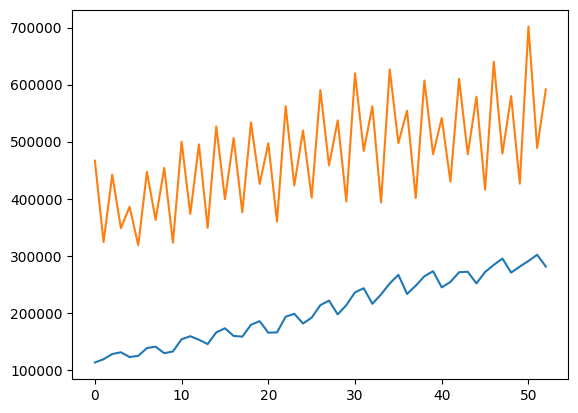

In [78]:
comp_data["imss"].plot()
comp_data["inegi"].plot()

> Parece ser que tienen la misma tendencia y que están altamente correlacionados, pero su coeficiente $\rho = 0.57$.

In [116]:
comp_data["const"] = np.ones(len(comp_data))
model = sm.OLS(comp_data.loc[:, "imss"].values, comp_data.loc[:, ["const", "inegi"]])
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.315
Method:                 Least Squares   F-statistic:                     24.96
Date:                Wed, 29 Nov 2023   Prob (F-statistic):           7.24e-06
Time:                        16:05:37   Log-Likelihood:                -644.72
No. Observations:                  53   AIC:                             1293.
Df Residuals:                      51   BIC:                             1297.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         3.7e+04   3.43e+04      1.079      0.286   -3.18e+04    1.06e+05
inegi          0.3526      0.071      4.996      0.000       0.211       0.494
==============================================================================
Omnibus:                        2.891   Durbin-Watson:                   1.317
Prob(Omnibus):                  0.236   Jarque-Bera (JB):                2.218
Skew:                           0.349   Prob(JB):                        0.330
Kurtosis:                       2.281   Cond. No.                     2.56e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.56e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

> No hay modelo.

## Estandarizando la matriz de coeficientes

In [148]:
coeffs_df

,covar_s0_g1,covar_s0_g2,covar_s0_g3,covar_s0_g4,covar_s0_g5,covar_s1_g11,covar_s1_g12,covar_s1_g13,covar_s2_g20,covar_s2_g21,...,covar_s8_g85,covar_s8_g86,covar_s8_g87,covar_s8_g88,covar_s8_g89,covar_s9_g91,covar_s9_g92,covar_s9_g93,covar_s9_g94,covar_s9_g99
covar_s0_g1,60259.249098,0.173001,-3.827673,-3.062745,621.914672,-8.226210,314.560722,3.048369,-0.046280,-0.088673,...,0.015414,0.009803,0.019338,0.016371,-0.018651,-0.014522,0.040648,-0.085941,-0.004444,-3.032327
covar_s0_g2,0.016808,17960.411944,-2.644416,2.693786,60.297486,-1.129978,64.980354,-0.015372,-0.002264,-0.000200,...,0.051334,-0.003958,-0.001228,-0.003405,-0.001115,-0.002948,0.013389,-0.069717,0.000958,-0.730983
covar_s0_g3,-0.000026,-0.000580,463.848170,-0.119206,1.160594,0.015955,-2.205729,0.033051,-0.000337,-0.000342,...,-0.001128,0.000300,0.000096,0.000332,-0.000070,0.000013,-0.000400,0.002821,-0.000072,0.023041
covar_s0_g4,-0.000014,0.001427,-0.163182,279.060954,4.084992,-0.017413,1.643056,-0.104916,0.001573,0.001464,...,0.001935,-0.000788,-0.000484,-0.000790,0.000690,-0.000092,0.002027,-0.008882,0.000174,0.118623
covar_s0_g5,0.000116,-0.000223,-0.005661,0.010551,17.909151,-0.002399,0.270012,0.000346,0.000021,-0.000112,...,0.000003,-0.000018,0.000022,-0.000021,-0.000011,-0.000014,0.000057,-0.000397,0.000000,0.004667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
covar_s9_g91,0.021787,-0.063078,1.106710,-8.667175,164.676304,-0.907576,42.007274,1.044361,-0.016602,-0.025738,...,-0.030709,0.006154,0.008027,0.009801,-0.009059,44118.103838,-0.017584,0.079965,-0.002119,-1.215677
covar_s9_g92,0.030048,-0.051476,-1.885321,4.916268,93.216118,-2.088359,19.604434,0.437255,-0.000733,-0.000717,...,0.076814,0.005670,-0.001670,0.003962,-0.002872,-0.005999,21906.815538,0.023131,-0.000360,0.112211
covar_s9_g93,0.001345,-0.008509,0.531196,-1.715370,8.969191,0.115835,-4.178187,0.441527,-0.006878,-0.004456,...,-0.007540,0.003311,0.000586,0.006349,-0.000686,-0.000891,0.000344,6027.924900,0.000018,0.394409
covar_s9_g94,0.071047,-0.153640,-1.430334,-6.191520,318.706338,-3.330228,99.075110,4.086887,-0.061939,-0.062220,...,-0.008974,0.010113,0.009554,0.034325,-0.009233,-0.014503,0.027484,0.098169,176734.084311,-8.876750


### Porcentaje de impacto entre grupos

In [143]:
coeffs_std = coeffs_df.apply(lambda x: x / sum(abs(x)), axis=1)
coeffs_std

,covar_s0_g1,covar_s0_g2,covar_s0_g3,covar_s0_g4,covar_s0_g5,covar_s1_g11,covar_s1_g12,covar_s1_g13,covar_s2_g20,covar_s2_g21,...,covar_s8_g85,covar_s8_g86,covar_s8_g87,covar_s8_g88,covar_s8_g89,covar_s9_g91,covar_s9_g92,covar_s9_g93,covar_s9_g94,covar_s9_g99
covar_s0_g1,9.840963e-01,2.825282e-06,-0.000063,-0.000050,0.010157,-0.000134,0.005137,4.978304e-05,-7.557931e-07,-1.448119e-06,...,2.517317e-07,1.601005e-07,3.158113e-07,2.673621e-07,-3.045974e-07,-2.371567e-07,6.638278e-07,-1.403507e-06,-7.257813e-08,-0.000050
covar_s0_g2,9.289013e-07,9.925830e-01,-0.000146,0.000149,0.003332,-0.000062,0.003591,-8.495286e-07,-1.251431e-07,-1.103226e-08,...,2.836958e-06,-2.187577e-07,-6.788033e-08,-1.881922e-07,-6.163171e-08,-1.629318e-07,7.399708e-07,-3.852915e-06,5.291855e-08,-0.000040
covar_s0_g3,-5.474493e-08,-1.241722e-06,0.992274,-0.000255,0.002483,0.000034,-0.004719,7.070397e-05,-7.212906e-07,-7.308376e-07,...,-2.413019e-06,6.422801e-07,2.048886e-07,7.110022e-07,-1.499195e-07,2.777221e-08,-8.549892e-07,6.035315e-06,-1.539803e-07,0.000049
covar_s0_g4,-4.870939e-08,4.996106e-06,-0.000571,0.977026,0.014302,-0.000061,0.005753,-3.673243e-04,5.508394e-06,5.125784e-06,...,6.775397e-06,-2.758150e-06,-1.695350e-06,-2.766661e-06,2.416916e-06,-3.224453e-07,7.097413e-06,-3.109763e-05,6.074606e-07,0.000415
covar_s0_g5,6.357597e-06,-1.221925e-05,-0.000311,0.000579,0.982596,-0.000132,0.014814,1.895945e-05,1.152501e-06,-6.141640e-06,...,1.379763e-07,-9.728356e-07,1.194806e-06,-1.160653e-06,-5.888811e-07,-7.545284e-07,3.122108e-06,-2.178617e-05,0.000000e+00,0.000256
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
covar_s9_g91,4.913323e-07,-1.422481e-06,0.000025,-0.000195,0.003714,-0.000020,0.000947,2.355159e-05,-3.743936e-07,-5.804236e-07,...,-6.925265e-07,1.387899e-07,1.810259e-07,2.210157e-07,-2.042908e-07,9.949157e-01,-3.965464e-07,1.803311e-06,-4.779074e-08,-0.000027
covar_s9_g92,1.363566e-06,-2.335987e-06,-0.000086,0.000223,0.004230,-0.000095,0.000890,1.984254e-05,-3.326005e-08,-3.251547e-08,...,3.485805e-06,2.572834e-07,-7.576928e-08,1.798032e-07,-1.303294e-07,-2.722158e-07,9.941262e-01,1.049660e-06,-1.632674e-08,0.000005
covar_s9_g93,2.224529e-07,-1.407341e-06,0.000088,-0.000284,0.001484,0.000019,-0.000691,7.302890e-05,-1.137706e-06,-7.370085e-07,...,-1.247073e-06,5.476783e-07,9.693801e-08,1.050138e-06,-1.134784e-07,-1.474263e-07,5.691694e-08,9.970232e-01,2.993820e-09,0.000065
covar_s9_g94,4.009587e-07,-8.670774e-07,-0.000008,-0.000035,0.001799,-0.000019,0.000559,2.306467e-05,-3.495590e-07,-3.511436e-07,...,-5.064531e-08,5.707416e-08,5.391701e-08,1.937149e-07,-5.210784e-08,-8.185007e-08,1.551054e-07,5.540265e-07,9.974129e-01,-0.000050


### Lineas de tendencia sectoriales

In [166]:
selected_data["Año"] = pd.to_datetime(selected_data["Año"])
dec_data = selected_data[selected_data["Año"].dt.month == 12] \
                        .groupby(["Año", "sector_economico_1"]) \
                        .sum() \
                        .drop("sector_economico_2", axis=1) \
                        .reset_index()
dec_data

,Año,sector_economico_1,ta
0,2010-12-31,0.0,57000.936713
1,2010-12-31,1.0,2179.192215
2,2010-12-31,2.0,151602.027532
3,2010-12-31,3.0,163108.305877
4,2010-12-31,4.0,88007.498456
...,...,...,...
125,2022-12-31,5.0,9672.675313
126,2022-12-31,6.0,374868.453596
127,2022-12-31,7.0,92834.640013
128,2022-12-31,8.0,352071.114729


In [179]:
pib_jal = pd.read_excel("./pib_jalisco_actividad.xlsx", skiprows=4)\
            .iloc[1:-3, :20] \
            .drop([x for x in range(2003, 2010)], axis=1)
pib_jal["Concepto"] = pib_jal["Concepto"].map(lambda x: x.strip()[0])
pib_jal.groupby(["Concepto"]).sum()

,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
Concepto,,,,,,,,,,,,
1,55802.037,52703.563,57514.461,57476.853,61023.777,62310.448,63564.395,67405.231,69931.177,71047.971,72836.639,73488.856
2,91381.563,98572.658,100149.993,99060.425,97729.501,106121.532,107657.844,110405.913,106195.835,101547.296,92524.090,97191.221
3,191863.576,190922.894,201183.253,211593.082,238602.489,249271.344,248424.317,252011.801,257487.448,262507.240,236406.206,249075.726
4,240498.649,256633.597,266364.129,271981.065,280923.321,288495.501,311282.417,312365.142,328855.823,328698.509,293733.749,323696.969
5,207419.580,213956.632,222809.856,229693.342,236543.118,248785.968,261743.874,274661.539,284391.414,290842.862,290755.959,291885.663
6,58631.273,59713.103,61538.704,62341.499,61396.156,59909.144,62444.693,62740.882,63930.058,65173.043,62063.293,63682.149
7,27178.931,27718.800,28551.476,29935.187,34748.828,33429.554,35983.321,37997.084,38111.677,37497.564,21814.024,31695.763
8,20814.163,20608.957,21729.407,21578.545,21746.671,21979.821,23187.895,23524.507,23563.235,23762.839,20534.547,20769.771
9,31782.065,32317.852,35444.720,34918.609,34542.901,34581.558,34840.792,35503.935,35609.355,35658.372,35537.366,35432.846


In [191]:
len_data = len(pib_jal.iloc[0, 1:])

In [300]:
lin_models = []

In [301]:
for sector in range(10):
    x = pib_jal.iloc[sector, 1:].values.astype(np.float32).reshape(-1, ) * 1_000_000
    y = dec_data[dec_data["sector_economico_1"] == sector].ta[:len_data].values
    x_df = pd.DataFrame({"x": x}) # pd.DataFrame({"x": x, "const": np.ones(len(x))})
    model = sm.OLS(y, x_df)
    res = model.fit()
    lin_models.append(res.params)
    print(res.rsquared)

0.9878731234100069
0.9622338755613349
0.9977327264202366
0.9698398994752111
0.9887396562470661
0.9804883489251409
0.9866627152989307
0.975253496803072
0.9795475320832708
0.9997390610783858


In [302]:
lin_models[0]

x    0.000001
dtype: float64

In [306]:
pd.DataFrame({"x": list(map(lambda x: x.x, lin_models))})

,x
0,1.222731e-06
1,1.071112e-06
2,1.159500e-05
3,2.450361e-06
4,4.973243e-07
5,7.643519e-08
6,2.498209e-06
7,3.229556e-06
8,7.273575e-06
9,1.711159e-06


In [310]:
coeffs_std.applymap(lambda x: str(x).replace(".", ",")).to_clipboard()

In [354]:
year = 2021
sector = 0
tsum = selected_data[(selected_data["Año"].dt.month == 12) &
                     (selected_data["Año"].dt.year == year) &
                     (selected_data["sector_economico_1"] == sector)]["ta"].sum()

(selected_data[(selected_data["Año"].dt.month == 12) &
              (selected_data["Año"].dt.year == year) &
              (selected_data["sector_economico_1"] == sector)]["ta"] / tsum).to_clipboard()
